In [1]:
import glob,os
import numpy as np
import pandas as pd
import re
from fitsio import FITS

# import astropy
from astropy.table import Table, setdiff, vstack,join

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.71
file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/DepthData/color_cut=9/"

filepath = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/" #r"/bsuscratch/shuleicao/Cardinalv3/"

# Load the cylinder richness data of the different depths

In [2]:
def load_and_process_data(file_path, depth):
    filename = f"RichnessDepth-Data/RichnessDepth_NogalZ&ColorCut_{depth}_02_035.dat"
    data_unsorted = Table.read(file_path + filename, format='ascii')
    
    data_sorted = Table(np.sort(data_unsorted, order='lam'))[::-1]
    print(f'D{depth}' ,len(data_sorted), len(np.unique(data_sorted['pixelid'])))
    
    return data_sorted

# Load and process richness data for different depths
cluster_1 = load_and_process_data(file_path, 1)
cluster_30 = load_and_process_data(file_path, 30)
cluster_60 = load_and_process_data(file_path, 60)
cluster_90 = load_and_process_data(file_path, 90)
cluster_120 = load_and_process_data(file_path, 120)

D1 109142 1665
D30 106081 1665
D60 105282 1665
D90 104534 1665
D120 103973 1665


# Load Halos data with Weak lensing profiles

In [4]:
### Load the halos with the DS and Sigma profiles
sigma_ds_profile =  Table(np.load(filepath+"correctfilev2.npy"))
print(len(sigma_ds_profile))
print(sum(np.all(sigma_ds_profile['Sigma'] == 0, axis=1)))
sigma_ds_profile = sigma_ds_profile[(np.all(sigma_ds_profile['Sigma'] != 0, axis=1)) & (sigma_ds_profile['pid']==-1)]
sigma_ds_profile['Sigma'] = sigma_ds_profile['Sigma']*1e12*h
sigma_ds_profile['DeltaSigma'] = sigma_ds_profile['DeltaSigma']*1e12*h
print(len(sigma_ds_profile))
sigma_ds_profile[:2]

1454571
167514
1208773


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,225027994363744.4 .. 4491195973346.023,1761882359377507.5 .. 21862032810104.79,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,228034835634536.3 .. 3157197076052.113,2073043573443353.5 .. 21317607969554.035,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462


# Load cluster-halos matched (RedMaPPer)

In [6]:
cluster_halos_red = Table(np.load(filepath + "HaloRun_Halo_Clusters_Lamgt0-1081991.npy")) #HaloRun_Halo_Clusters-_Lamgt0-1081991.npy
cluster_halos_red = Table(join(sigma_ds_profile,cluster_halos_red, keys_right=['halo_id','m200'],keys_left=['haloid','Mvir']))
# cluster_halos_red = cluster_halos_red[np.all(cluster_halos_red['Sigma'] != 0, axis=1)]
print(len(cluster_halos_red))
cluster_halos_red = cluster_halos_red[(cluster_halos_red['z']>=0.2) & (cluster_halos_red['z']<0.35) & (cluster_halos_red['lambda']>=10)]
cluster_halos_red = Table(np.sort(cluster_halos_red,order='lambda'))[::-1]
print(len(cluster_halos_red))

lamranges = [(10,30), (30,45), (45,60), (60,500)]
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)
grouped_cl_halos_red = cluster_halos_red.group_by(['lambda_range'])

cluster_halos_red[:2]

303308
3618


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta,halo_id,id,m200,ra,dec,z,refmag,refmag_err,mag,mag_err,mem_match_id,lambda,lambda_e,z_lambda,z_lambda_e,cg_spec_z,z_spec_init,z_init,r_lambda,r_mask,scaleval,maskfrac,zred,zred_e,zred_chisq,chisq,z_lambda_niter,ebv_mean,lnlamlike,lncglike,lnlike,ra_orig,dec_orig,w,dlambda_dz,dlambda_dz2,dlambdavar_dz,dlambdavar_dz2,z_lambda_raw,z_lambda_e_raw,bkg_local,lim_exptime,lim_limmag,lim_limmag_hard,lambda_c,lambda_ce,ncent_good,maskgal_index,pzbins,pz,ra_cent,dec_cent,id_cent,lambda_cent,zlambda_cent,p_cen,q_cen,p_fg,q_miss,p_sat,p_c,lambda_range
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100],int64,int64,float32,float64,float64,float32,float32,float32,float32[4],float32[4],int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32[21],float32[21],float64[5],float64[5],int64[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32[5],float32[5],object
11296394,848200000000000.0,89.7978,36.3061,0.312424,2.3237262357414448,0.396733,-1,0.472551,1038735000000000.0,2.49972,8002959297672269.0 .. 10067532576947.773,108422285347460.78 .. 2808226895866.3,1365623186146656.5 .. 7525493716647.5625,0.0 .. -0.14807260052761265,0.0 .. 0.19221822744931966,14.212952891480937 .. 1.0,222.84181937311834 .. 0.0,11296394,383000701748,848200000000000.0,19.896453906443554,-30.581842473875867,0.31408668,18.19168,0.007523822,20.543314 .. 18.19168,0.011530025 .. 0.007523822,61,155.40663,3.785706,0.3099862,0.0077679725,0.31408668,0.0,0.0,1.0921792,1.6382688,1.0074236,0.007375991,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.259746,-3257.541,204.5299,-76412.66,0.0,0.0,0.0,0.37487796,22.802382,23.33665,0.0,0.0,0,9,0.27838713 .. 0.3415853,3.1853256e-06 .. 5.8442392e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"
13388896,778000000000000.0,57.5157,32.2128,0.305834,2.271855500821018,0.605395,-1,0.703273,933147000000000.0,2.41201,6802313821327866.0 .. 9823300346024.344,234616197231637.25 .. 3352115886290.196,1488188034218134.8 .. 11530002125147.176,2.2572884501734226e-06 .. 0.7567861787328568,1.2660154143969328e-07 .. 0.12251820961768442,14.777693449326385 .. 1.0,220.36618833208394 .. 0.0,13388896,24001083291,778000000000000.0,50.50666918428469,-27.473529332920776,0.3070983,21.539202,0.05202452,23.251038 .. 21.539202,0.053721827 .. 0.05202452,90,148.80124,3.8551364,0.29958257,0.008052958,0.3070983,0.0,0.0,1.0827328,1.6240993,1.0056895,0.0053783385,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7140446,-2090.9375,60.07529,-71125.53,0.0,0.0,0.0,0.34541553,22.71167,23.33665,0.0,0.0,0,13,0.26811022 .. 0.33105496,1.1906825e-05 .. 7.1994373e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"


# Merge halos with clusters (DepthMapper)

In [8]:
# List of cluster tables and suffix values
cluster_tables = [cluster_1, cluster_30, cluster_60, cluster_90, cluster_120]  #0, cluster_150, cluster_180, cluster_210
suffix_values = [1, 30, 60, 90, 120] #, 150, 180, 210

halo_cluster_tables = {}

# Iterate over the tables and suffix values
for i, (cluster_table, suffix) in enumerate(zip(cluster_tables, suffix_values), 1):
    halo_table_name = f"cluster_halo_{suffix}"

    # Perform the join and other operations
    halo_table = Table(np.sort(join(cluster_table, sigma_ds_profile, keys_left=['haloid','redshift'], keys_right=['haloid','Redshift'], join_type='inner')))[::-1]
    halo_cluster_tables[halo_table_name] = halo_table #[np.unique(halo_table['haloid_1'], return_index=True)[1]]

    print(f"Length of {halo_table_name}: {len(halo_table)}")

cluster_halo_1 = Table(halo_cluster_tables['cluster_halo_1'])
cluster_halo_30 = Table(halo_cluster_tables['cluster_halo_30'])
cluster_halo_60 = Table(halo_cluster_tables['cluster_halo_60'])
cluster_halo_90 = Table(halo_cluster_tables['cluster_halo_90'])
cluster_halo_120 = Table(halo_cluster_tables['cluster_halo_120'])

Length of cluster_halo_1: 77249
Length of cluster_halo_30: 75062
Length of cluster_halo_60: 74395
Length of cluster_halo_90: 73807
Length of cluster_halo_120: 73392


In [9]:
Rmin = 0.1
Rmax = 50
pimax = 100
n_decade = (np.log10(Rmax)-np.log10(Rmin))
nrp_per_decade = 10
n_rp = int(nrp_per_decade*n_decade + 1 + 0.001) ## adding the inner most bin
lnrp = np.linspace(np.log(Rmin), np.log(Rmax), 15) # n_rp
bins = np.exp(lnrp) #/0.70

In [10]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            weight_norm += weight
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            pdf2_list[iz, iM] = len(lnM_all[select_all])

            if weight > 0 and len(lnM_all[select_all]) > 0:
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) 
    profile_weighted /= weight_norm

    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list

    return profile_weighted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


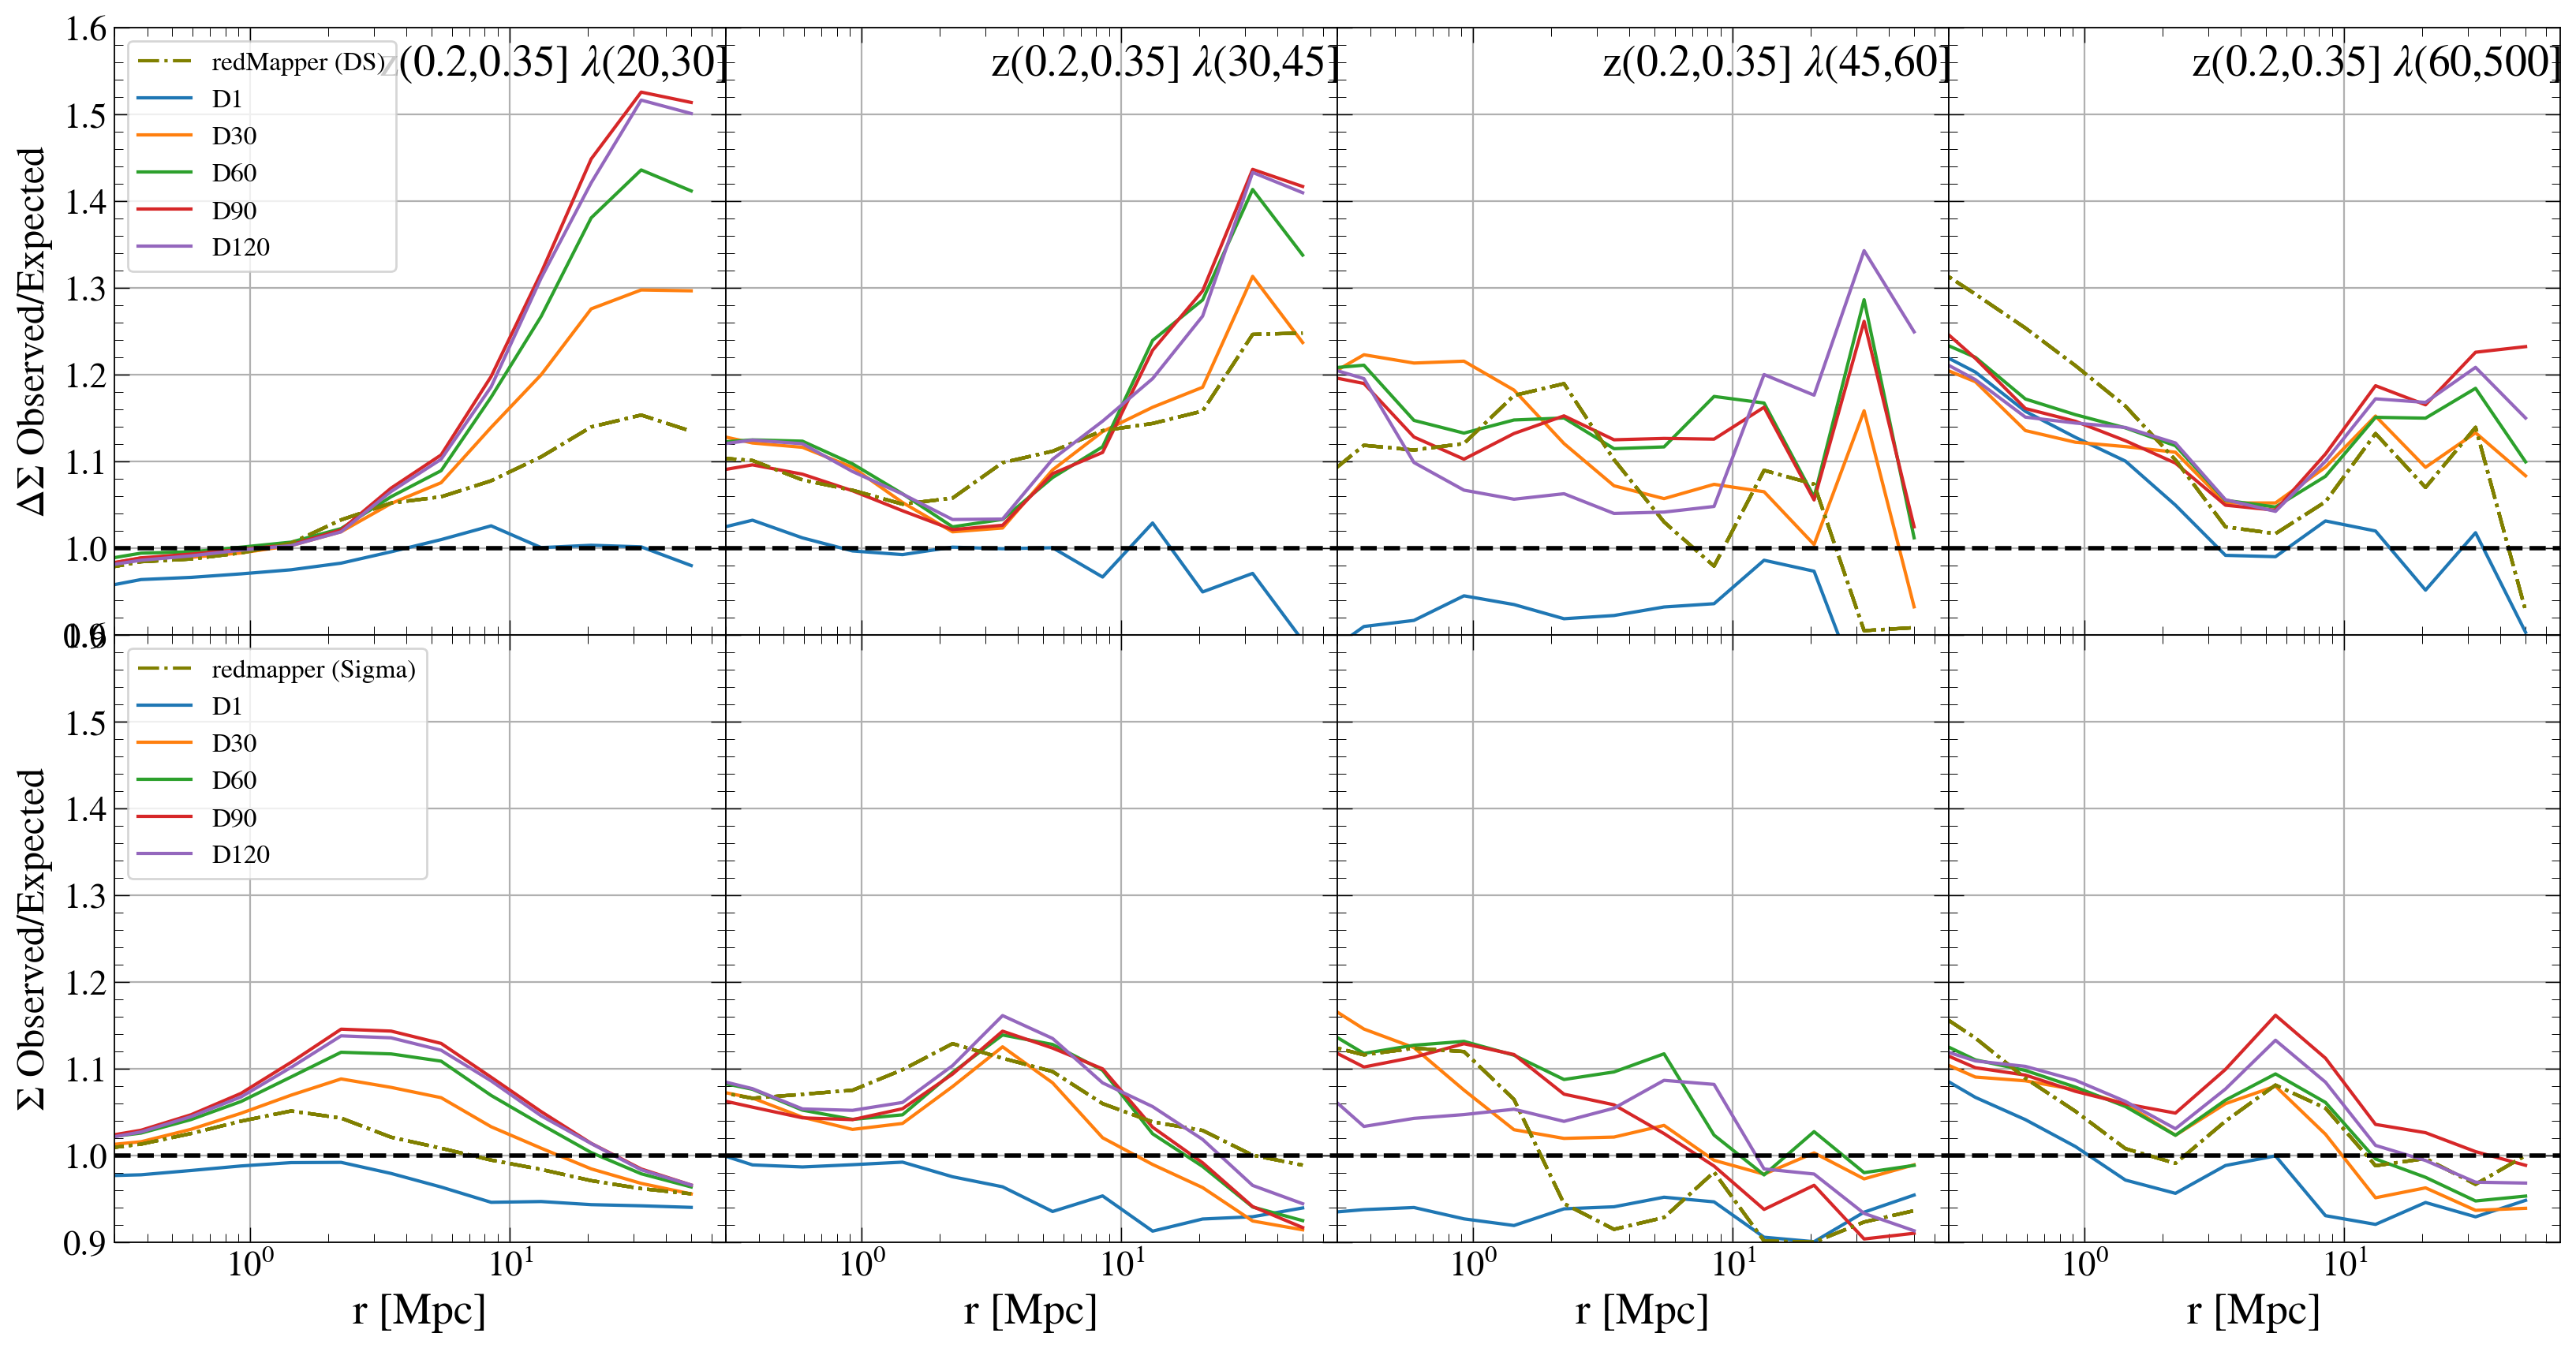

In [11]:
underlying_halos = sigma_ds_profile[(sigma_ds_profile['Redshift'] >= 0.2) & (sigma_ds_profile['Redshift'] < 0.35)]
lnM_All = np.log10(underlying_halos['Mvir'])
z_All = underlying_halos['Redshift']
profile_All = underlying_halos['Sigma']
profile_All_ds = underlying_halos['DeltaSigma']

# Function to select clusters based on lambda values and calculate ratios
def select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All):
    sorted_indices = np.argsort(np.array(cluster_halo['lam']))[::-1]
    sel_clusters = cluster_halo[sorted_indices[:num_clusters_in_bin]]
    cluster_halo.remove_rows(sorted_indices[:num_clusters_in_bin])
    
    lnM_sel = np.log10(sel_clusters['mass'])
    z_sel = sel_clusters['redshift']
    profile_sel = sel_clusters['Sigma']
    profile_sel_ds = sel_clusters['DeltaSigma']
    
    expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds)
    expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All)
    
    ratio_ds = np.array(profile_sel_ds.mean(axis=0)) / np.array(expected_ds)
    ratio_sigma = np.array(profile_sel.mean(axis=0)) / np.array(expected_sigma)
    
    return ratio_ds, ratio_sigma

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
D = [1, 30, 60, 90, 120, 150,180,210]
for lambda_group in reversed(grouped_cl_halos_red.groups):
    lnM_sel_red = np.log10(lambda_group['Mvir'])
    z_sel_red = lambda_group['z']
    profile_sel_red = lambda_group['Sigma']
    profile_sel_ds_red = lambda_group['DeltaSigma']
    
    num_clusters_in_bin = len(lambda_group)
    
    expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)
    
    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)
    
    # Iterate over different cluster_halo datasets
    for i, cluster_halo in enumerate([cluster_halo_1, cluster_halo_30, cluster_halo_60, cluster_halo_90, cluster_halo_120]): #, cluster_halo_150, cluster_halo_180, cluster_halo_210
        ratio_ds, ratio_sigma = select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All)

        # Plotting
        lambda_value = float(re.findall(r'\d+', lambda_group['lambda_range'][0])[0])
        col_index1 = int(lambda_value) // 15 - 1 
        col_index = col_index1 if col_index1 > 0 else 0

        axes[0, col_index].plot(bins, ratio_ds_red, label='redMapper (DS)' if i == 0 else None, linestyle='dashdot',color='olive')
        axes[0, col_index].plot(bins, ratio_ds, label=f'D{D[i]}')
        axes[0, col_index].set_ylim([0.5, 2])
        
        axes[1, col_index].plot(bins, ratio_sigma_red, label='redmapper (Sigma)' if i == 0 else None, linestyle='dashdot',color='olive')
        axes[1, col_index].plot(bins, ratio_sigma, label=f'D{D[i]}')
        axes[1, col_index].set_ylim([0.9, 1.6])
                                    
    # Set plot properties
    for row_index, ax_row in enumerate(axes):
        ax_row[col_index].set_xscale('log')
        ax_row[col_index].set_ylabel('$\Delta\Sigma$ Observed/Expected' if row_index == 0 else '$\Sigma$ Observed/Expected', fontsize=18)
        ax_row[0].legend(loc='upper left', fontsize=12)

    title = f'z(0.2,0.35] $\lambda${lambda_group["lambda_range"][0]}'
    title_y = 1.1 if row_index > 3 else 0.9
    axes[0, col_index].set_title(title, loc='right', y=title_y, fontsize=20)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axes.flat:
    ax.label_outer()
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]', fontsize=20)

for ax in axes[1, :]:
    ax.set_xlim(0.3, None)

plt.show()
